In [5]:
import pandas as pd
import numpy as np
train_x = pd.read_csv('../data/train_x.csv')
latitude, longitude = train_x['latitude'], train_x['longitude']
train_x.head()

,Unnamed: 0,wals_code,name,latitude,longitude,genus,family,countrycodes,Distance_Contrasts_in_Demonstratives,Order_of_Object_and_Verb,...,Locus_of_Marking:_Whole-language_Typology,"Genitives,_Adjectives_and_Relative_Clauses",Pronominal_and_Adnominal_Demonstratives,M_in_First_Person_Singular,Inflectional_Synthesis_of_the_Verb,Expression_of_Pronominal_Subjects,Optional_Double_Negation_in_SVO_languages,Front_Rounded_Vowels,Third_Person_Zero_of_Verbal_Person_Marking,Inclusive/Exclusive_Forms_in_Pama-Nyungan
0,0,abd,Abidji,5.666667,-4.583333,Kwa,Niger-Congo,CI,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,abe,Arabic (Beirut),33.916667,35.500000,Semitic,Afro-Asiatic,LB,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,abi,Abipón,-29.000000,-61.000000,South Guaicuruan,Guaicuruan,AR,NaN,?,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 None,3 Zero in some 3sg forms,NaN
3,3,abk,Abkhaz,43.083333,41.000000,Northwest Caucasian,Northwest Caucasian,GE,2 Two-way contrast,1 OV,...,1 Head-marking,6 Highly differentiated,?,1 No m in first person singular,?,?,NaN,?,?,NaN
4,4,abm,Alabama,32.333333,-87.416667,Muskogean,Muskogean,US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,?,NaN,NaN


In [6]:
train_x = train_x.drop(columns=['Unnamed: 0', 'wals_code', 'latitude', 'longitude'])
train_x = train_x.to_numpy()

In [7]:
import numpy as np 

def hamming_distance(x1, x2):
    dist = 0
    for i in range(len(x1)):
        if x1[i] == '?' or x2[i] == '?' or x1[i] != x2[i]:
            dist += 1
    
    return dist

dist_matrix = np.zeros(shape=(train_x.shape[0], train_x.shape[0]))
for i in range(len(train_x)):
    for j in range(i+1, len(train_x)):
        dist_matrix[i][j] = hamming_distance(train_x[i], train_x[j])
        dist_matrix[j][i] = dist_matrix[i][j]

In [8]:
closest = []
for i in dist_matrix:
    closest.append(np.argsort(i)[1:])

In [20]:
from collections import Counter
import math
import evaluate

golden_raw = pd.read_csv('../data/train_y.csv')
columns = golden_raw.columns
golden = golden_raw.drop(columns=['Unnamed: 0', 'wals_code', 'latitude', 'longitude']).to_numpy()

def write_results(predicted, raw):
    form_copy = np.array(raw, copy=True)
    result = np.concatenate([form_copy[:,:4], predicted], axis=1)

    result = pd.DataFrame(data=result, columns=columns)
    result = result.fillna('nan')
    result.to_csv('../outputs/knn.csv', index=False)

def knn(k, x, x_to_predict, golden, distance_matrix_sorted, fall_back, raw):
    tmp = np.array(x_to_predict, copy=True)
    for i in range(len(x_to_predict)):
        closest_langs = distance_matrix_sorted[i][:k]
        should_fill = x_to_predict[i] == '?'
        known = x[closest_langs][:,should_fill]
        counters = [Counter() for _ in range(len(known[0]))]
        for j in known:
            for l in range(len(j)):
                if type(j[l]) is str and j[l] != '?':
                    counters[l][j[l]] += 1
       
        for counter, idx in zip(counters, np.argwhere(should_fill==True)):
            idx=idx[0]
            prediction = counter.most_common(1)
            if len(prediction) == 0:
                prediction = fall_back(x_to_predict[i], idx)
            else:
                prediction = prediction[0][0]
                
            x_to_predict[i][idx] = prediction          

    acc = evaluate.evaluate(tmp, x_to_predict, golden)
    write_results(x_to_predict, raw)
    return acc

In [19]:
dist_matrix = np.zeros(shape=(train_x.shape[0], train_x.shape[0]))
for i in range(len(train_x)):
    for j in range(len(train_x)):
        dist_matrix[i][j] = hamming_distance(train_x[i], train_x[j])

closest = []
for i in dist_matrix:
    closest.append(np.argsort(i)[1:])
        
class MostCommon:
    def __init__(self, data):
        self.global_counters = [Counter() for _ in range(data.shape[1])]
        for lang in data:
            for feature_idx in range(data.shape[1]):
                if type(lang[feature_idx]) is str and lang[feature_idx] != '?':
                    self.global_counters[feature_idx][lang[feature_idx]] += 1
        
    def __call__(self, x, idx):
        return self.global_counters[idx].most_common(1)[0][0]
    
result = []
best = 0
for i in range(1,train_x.shape[0]):#train_x.shape[0]):
    result.append(knn(i, train_x, np.array(train_x, copy=True), golden, closest, MostCommon(train_x), golden_raw.to_numpy()))
    if best < result[-1]:
        print()
        print(i, result[-1])
        best = result[-1]
    else:
        print(i, end=', ')


1 0.5875936329588015

2 0.5988295880149813

3 0.6042602996254681

4 0.611376404494382

5 0.6159644194756554

6 0.6203651685393259

7 0.6257958801498127

8 0.6304307116104869

9 0.6352059925093633

10 0.6393726591760299

11 0.6432584269662921

12 0.6449906367041198

13 0.647378277153558

14 0.6494382022471911

15 0.649812734082397

16 0.6514044943820225

17 0.6531367041198501
18, 19, 20, 21, 22, 
23 0.6542602996254682
24, 25, 
26 0.6546816479400749
27, 28, 
29 0.6549157303370786
30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 

KeyboardInterrupt: 

In [22]:
     
class MostCommon:
    def __init__(self, data):
        self.global_counters = [Counter() for _ in range(data.shape[1])]
        for lang in data:
            for feature_idx in range(data.shape[1]):
                if type(lang[feature_idx]) is str and lang[feature_idx] != '?':
                    self.global_counters[feature_idx][lang[feature_idx]] += 1
        
    def __call__(self, x, idx):
        return self.global_counters[idx].most_common(1)[0][0]
    
class MostCommonGenus:
    def __init__(self, data):
        self.data = data
        self.most_common = MostCommon(data)
        
    def __call__(self, x, idx):
        data = self.data[self.data[:,1] == x[1]]
        counter = Counter()
        for lang in data:
            if type(lang[idx]) is str and lang[idx] != '?':
                counter[lang[idx]] += 1
        if len(counter.most_common(1)) == 0:
            return None
        else:
            return counter.most_common(1)[0][0]
        
class MostCommonFamily:
    def __init__(self, data):
        self.data = data
        self.most_common = MostCommon(data)
        
    def __call__(self, x, idx):
        data = self.data[self.data[:,2] == x[2]]
        counter = Counter()
        for lang in data:
            if type(lang[idx]) is str and lang[idx] != '?':
                counter[lang[idx]] += 1
        if len(counter.most_common(1)) == 0:
            return None
        else:
            return counter.most_common(1)[0][0]
        
class PriorityFallbacks:
    def __init__(self, data, fallbacks):
        self.data = data
        self.fallbacks = fallbacks
        self.fallbacks.append(MostCommon(data))
    
    def __call__(self, x, idx):
        for fallback in self.fallbacks:
            res = fallback(x, idx)
            if res is not None:
                return res
            
    
    
golden = pd.read_csv('../data/dev_y.csv').drop(columns=['Unnamed: 0', 'wals_code', 'latitude', 'longitude']).to_numpy()
dev_x_raw = pd.read_csv('../data/dev_x.csv')
dev_x = dev_x_raw.drop(columns=['Unnamed: 0', 'wals_code', 'latitude', 'longitude']).to_numpy()

dist_matrix = np.zeros(shape=(dev_x.shape[0], train_x.shape[0]))
for i in range(len(dev_x)):
    for j in range(len(train_x)):
        dist_matrix[i][j] = hamming_distance(dev_x[i], train_x[j])

closest = []
for i in dist_matrix:
    closest.append(np.argsort(i)[1:])
    
results = []
mc_genus = MostCommonGenus(train_x)
mc_family = MostCommonFamily(train_x)
fallbacks = [
    PriorityFallbacks(train_x, [mc_family]),
    PriorityFallbacks(train_x, [mc_genus]),
    PriorityFallbacks(train_x, []),
    PriorityFallbacks(train_x, [mc_family, mc_genus]),
    PriorityFallbacks(train_x, [mc_genus, mc_family]),
]
for fallback in fallbacks:
    tmp = []
    for n in range(1,30):
        tmp.append(knn(n, train_x, np.array(dev_x, copy=True), golden, closest, fallback, dev_x_raw.to_numpy()))
    results.append(tmp)

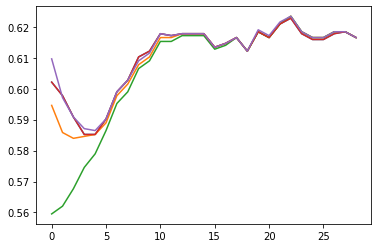

In [24]:
import matplotlib.pyplot as plt
for i in results:
    plt.plot(i)

In [25]:
for i in results:
    print(np.max(i))

0.6228070175438597
0.6234335839598998
0.6234335839598998
0.6228070175438597
0.6234335839598998
